In [1]:
import numpy as np
import pandas as pd
from river import optim
from river import metrics
from river.drift import ADWIN, EDDM
from sail.models.auto_ml.tune import SAILTuneGridSearchCV
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.models.river.linear_model import LogisticRegression
from sail.models.auto_ml.auto_pipeline import SAILAutoPipeline
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
from sail.transfomers.river.preprocessing import StandardScaler

#### Load Data


In [2]:
X = pd.read_csv("../../datasets/agrawal.csv").head(50000)

y = X["class"]
X.drop("class", axis=1, inplace=True)

#### Model Definition


In [3]:
logistic_reg = LogisticRegression(optimizer=optim.SGD(0.1))
random_forest = AdaptiveRandomForestClassifier(n_models=10)

#### Create SAIL Pipeline


In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", "passthrough"),
]
sail_pipeline = SAILPipeline(steps=steps, scoring=metrics.Accuracy)

#### HPO Params


In [5]:
params_grid = [
    {
        "classifier": [logistic_reg],
        "classifier__l2": [0.1, 0.9],
        "classifier__intercept_init": [0.2, 0.5],
    },
    {
        "classifier": [random_forest],
        "classifier__n_models": [5, 10],
        "Imputer": ["passthrough"],
    },
]

# params_grid = {
#     "classifier__l2": [0.1, 0.9],
#     "classifier__intercept_init": [0.2, 0.5],
# }


#### Create Model Instance


In [6]:
auto_pipeline = SAILAutoPipeline(
    pipeline=sail_pipeline,
    pipeline_params_grid=params_grid,
    search_method=SAILTuneGridSearchCV,
    search_method_params={
        "max_iters": 1,
        "early_stopping": False,
        "mode": "max",
        "scoring": "accuracy",
        "pipeline_auto_early_stop": False,
        "keep_best_configurations": 2
    },
    search_data_size=1000,
    incremental_training=True,
    drift_detector=EDDM(),
    pipeline_strategy="DetectAndIncrement",
)

[2023-06-30 00:05:42:36] - INFO - SAIL : Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']


#### Start Training


In [7]:
y_preds = []
y_true = []
batch_size = 50

for start in range(0, 2001, batch_size):

    end = start + batch_size

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000: # search_data_size is 1000
        preds = auto_pipeline.predict(X_train)
        y_preds.extend(list(preds))
        y_true.extend(list(y_train))

    auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])


SAIL Pipeline Tuning in progress... [Elapsed: 7.36s, CPU=10, Memory=31.7, Class=SAILTuneGridSearchCV]
[2023-06-30 00:05:52:141] - INFO - SAIL : Pipeline tuning completed. Shutting down Ray cluster...
[2023-06-30 00:05:54:195] - INFO - SAIL : Found best params: {'Imputer': 'passthrough', 'classifier': AdaptiveRandomForestClassifier(), 'classifier__n_models': 10}


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00096s, Metric=Accuracy, Score=0]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.045s, Batch Size=50, Score=0.92]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00102s, Metric=Accuracy, Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.046s, Batch Size=50, Score=0.95]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00124s, Metric=Accuracy, Score=0.95]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.046s, Batch Size=50, Score=0.92]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00067s, Metric=Accuracy, Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.050s, Batch Size=50, Score=0.915]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00080s, Metric=Accuracy, Score=0.915]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.046s, Batch Size=50, Score=0.904]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00099s, Metric=Accuracy, Score=0.904]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.047s, Batch Size=50, Score=0.9]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00089s, Metric=Accuracy, Score=0.9]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.050s, Batch Size=50, Score=0.909]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00160s, Metric=Accuracy, Score=0.909]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.060s, Batch Size=50, Score=0.905]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00176s, Metric=Accuracy, Score=0.905]
SAIL Drift detection:  14%=          [Points: 7/50, Elapsed:0.0026s, Detector=EDDM, Batch Size=50, Drift=Yes]
[2023-06-30 00:05:54:850] - INFO - SAIL : Drift Detected in the data. Final Estimator will be incrementally trained on the next train()
[2023-06-30 00:05:54:850] - WARNING - SAIL : The current best pipeline is STALE. Pipeline becomes stale when data drift occurs. You can call 'train' with fresh data to get the best pipeline.


>>>--------------------------------------------------------------------------------------------


SAIL Model Partial fit: 100%========== [Steps: 1/1, ETA: 00:00<00:00, Total:0.051s, Batch Size=50, Score=0.905]


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00075s, Metric=Accuracy, Score=0.905]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0014s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.047s, Batch Size=50, Score=0.898]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00099s, Metric=Accuracy, Score=0.898]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.048s, Batch Size=50, Score=0.894]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00115s, Metric=Accuracy, Score=0.894]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0017s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.051s, Batch Size=50, Score=0.887]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00119s, Metric=Accuracy, Score=0.887]
SAIL Drift detection:  88%========   [Points: 44/50, Elapsed:0.0019s, Detector=EDDM, Batch Size=50, Drift=Yes]
[2023-06-30 00:05:55:176] - INFO - SAIL : Drift Detected in the data. Final Estimator will be incrementally trained on the next train()
[2023-06-30 00:05:55:176] - WARNING - SAIL : The current best pipeline is STALE. Pipeline becomes stale when data drift occurs. You can call 'train' with fresh data to get the best pipeline.


>>>--------------------------------------------------------------------------------------------


SAIL Model Partial fit: 100%========== [Steps: 1/1, ETA: 00:00<00:00, Total:0.049s, Batch Size=50, Score=0.887]


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00118s, Metric=Accuracy, Score=0.887]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.054s, Batch Size=50, Score=0.883]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00102s, Metric=Accuracy, Score=0.883]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.056s, Batch Size=50, Score=0.883]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00127s, Metric=Accuracy, Score=0.883]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.048s, Batch Size=50, Score=0.883]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00118s, Metric=Accuracy, Score=0.883]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0015s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.047s, Batch Size=50, Score=0.879]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00083s, Metric=Accuracy, Score=0.879]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.041s, Batch Size=50, Score=0.881]              


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score [Elapsed: 0.00085s, Metric=Accuracy, Score=0.881]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Total:0.050s, Batch Size=50, Score=0.886]              


#### Classification Report


In [8]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       688
           1       0.94      0.70      0.80       362

    accuracy                           0.88      1050
   macro avg       0.90      0.84      0.86      1050
weighted avg       0.89      0.88      0.88      1050



#### Plot confusion matrix


<Axes: >

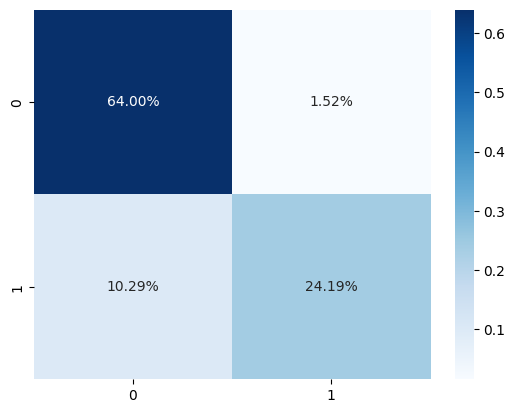

In [9]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')